In [1]:
import re
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def resize_paragraph(image, labels, target_size = 1024):
    min_x = min([label[0] for label in labels])
    min_y = min([label[1] for label in labels])
    max_x = max([label[0] + label[2] for label in labels])
    max_y = max([label[1] + label[3] for label in labels])

    crop_image = image[min_y:max_y, min_x:max_x]
    padding = random.randint(25, 40)
    size = max(crop_image.shape) + padding * 2

    final_image = np.ones((size, size), dtype=np.uint8) * 255

    # 计算开始位置
    start_x = (size - crop_image.shape[1]) // 2
    start_y = (size - crop_image.shape[0]) // 2
    final_image[start_y:start_y + crop_image.shape[0], start_x:start_x + crop_image.shape[1]] = crop_image

    for label in labels:
        # 减去最小值，然后加上开始位置
        label[0] = (label[0] - min_x + start_x) * target_size / size
        label[1] = (label[1] - min_y + start_y) * target_size / size
        label[2] = label[2] * target_size / size
        label[3] = label[3] * target_size / size
    
    final_image = cv2.resize(final_image, (target_size, target_size))
    return final_image, labels

def __get_char_img():
    Digits_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Digits"
    Letters_Upper_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Upper"
    Letters_Lower_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Lower"
    BHMSD_Images_folder = "/root/autodl-tmp/APS360_Project/Datasets/BHMSD_Unzip/bhmsds/symbols"
    digits_files = [os.listdir(os.path.join(Digits_folder, str(i))) for i in range(10)]
    lower_files = {chr(i): os.listdir(os.path.join(Letters_Lower_folder, chr(i))) for i in range(97, 123)}
    upper_files = {chr(i): os.listdir(os.path.join(Letters_Upper_folder, chr(i))) for i in range(65, 91)}
    uppercase = [chr(i) for i in range(65, 91)]
    lowercase = [chr(i) for i in range(97, 123)]
    digits = [str(i) for i in range(10)]

    def get_char_img(char: str, size: tuple|list) -> np.ndarray:
        # Get the image of the character
        # The image is a 28x28 numpy array
        # The image is a grayscale image, 0 is black, 255 is white
        # The image is of type np.uint8
        char_image_path = None
        char_image = None
        
        if char in digits:
            char_image_path = os.path.join(Digits_folder, char, np.random.choice(digits_files[int(char)]))
        elif char in uppercase:
            char_image_path = os.path.join(Letters_Upper_folder, char, np.random.choice(upper_files[char]))
        elif char in lowercase:
            char_image_path = os.path.join(Letters_Lower_folder, char, np.random.choice(lower_files[char]))
        elif char == '.':
            Images = [f for f in os.listdir(BHMSD_Images_folder) if f.startswith("dot")]
            if Images:
                char_image_path = os.path.join(BHMSD_Images_folder, np.random.choice(Images))
                char_image = cv2.imread(char_image_path, cv2.IMREAD_GRAYSCALE)
                char_image = cv2.resize(char_image, (10, 10))
        
        if char_image_path and os.path.exists(char_image_path):
            if char_image is None:
                char_image = cv2.imread(char_image_path, cv2.IMREAD_GRAYSCALE)
        # print(char_image_path)
        char_image = cv2.resize(char_image, size)
        return char_image
    
    return get_char_img

get_char_img = __get_char_img()

def get_word_img(word: str, size: tuple|list) -> np.ndarray:
    # Get the image of the word
    # The image is a 28x?? numpy array
    # The image is a grayscale image, 0 is black, 255 is white
    # The image is of type np.uint8
    
    # create a new background image to paste the characters onto
    image = np.ones((28, 28*len(word)), dtype=np.uint8) * 255
    for i, char in enumerate(word):
        char_img = get_char_img(char, (28, 28))
        # paste the char_img onto the image
        image[:, i*28:(i+1)*28] = char_img
    image = cv2.resize(image, size)
    return image

def make_img(labels):
    # make an image from the labels
    # labels: [[x, y, w, h, word], [x, y, w, h, word], ...]
    # The image is a 1024x1024 numpy array
    # return the image and the transformed labels

    # make a new background image to paste the words onto
    image = np.ones((3360, 3600), dtype=np.uint8) * 255

    for x, y, w, h, word in labels:
        word_img = get_word_img(word, (w, h))
        # paste the word_img onto the image
        image[y:y+h, x:x+w] = word_img
    
    image, labels = resize_paragraph(image, labels)

    return image, labels

In [3]:
def generate_labels(paragraph):
    # Define the scale
    line_height = 28

    # Define the basic variable
    labels = []
    current_x = random.randint(20, 30)
    current_y = random.randint(20, 30)
    temp_word = ""
    temp_start_x = 0

    # Loop through the paragraph
    for char in paragraph:
        space_width = random.randint(20, 30)    # Random space width
        # If meet with Space or Enter
        if char ==" " or char == "\n":
            if temp_word:
                labels.append([temp_start_x, current_y, current_x - temp_start_x, line_height, temp_word])  # [top-left x, top-left y, width, height, word]
                temp_word = ""
            if char == " ":
                current_x += space_width
            if char == "\n":
                current_y += line_height + random.randint(20, 35)
                current_x = random.randint(20, 30)
        # If meet with Dot
        elif char == ".":
            if temp_word:
                labels.append([temp_start_x, current_y, current_x - temp_start_x, line_height, temp_word])
                temp_word = ""
            labels.append([current_x, current_y, 10, line_height, "."])
            current_x += 10 + space_width
        # Appending the characters into the list
        else:
            if not temp_word:
                temp_start_x = current_x
            temp_word += char
            current_x += 28
    # Append the last word
    if temp_word:
        labels.append([temp_start_x, current_y, current_x - temp_start_x, line_height, temp_word])

    return labels


def process_paragraph(file):
    # Read the txt file
    texts = open(file, "r").read()

    # Define the basic variables
    word_count = 0
    paragraphs = []
    current_paragraph = ""
    current_word = ""

    # Define the acceptable characters
    uppercase = [chr(i) for i in range(65, 91)]
    lowercase = [chr(i) for i in range(97, 123)]
    digits = [i for i in range(10)]

    # Loop through the text
    for char in texts:
        if char.isalnum():
            current_word += char
        else:
            if current_word:
                word_count += 1
                current_paragraph += current_word
                current_word = ""
            if char == "\n":
                current_paragraph += "\n"
            elif char == "\r":
                continue
            elif re.match(r'[^\w\s]', char) or char == ' ':
                current_paragraph += char

        # If the word count reaches 90, append the paragraph
        if word_count == 90:
            paragraphs.append(current_paragraph)
            current_paragraph = ""
            word_count = 0

    # Append the last paragraph
    if current_paragraph or current_word:
        current_paragraph += current_word
        paragraphs.append(current_paragraph)
    
    # Clean the paragraphs
    cleaned_paragraphs = []

    # Loop through the paragraphs
    for paragraph in paragraphs:
        temp_paragraph = ""
        for char in paragraph:
            if char in uppercase or char in lowercase or char in digits or char == "." or char == "\n" or char == " ":
                temp_paragraph += char
            else:
                temp_paragraph += " "
        cleaned_paragraphs.append(temp_paragraph)
    
    return cleaned_paragraphs

In [4]:
# 生成word图片给CRNN做训练
def resize_word(image):
    # Get the image size
    width, height = image.shape[1], image.shape[0]

    # Define the scale
    new_length = max(width, height)

    # Define the new image
    new_image = np.ones((new_length, new_length), dtype=np.uint8) * 255

    # Place the image into the new image
    new_image[(new_length - height) // 2:(new_length - height) // 2 + height, (new_length - width) // 2:(new_length - width) // 2 + width] = image

    # Resize the image
    new_image = cv2.resize(new_image, (128, 128))
    
    return new_image

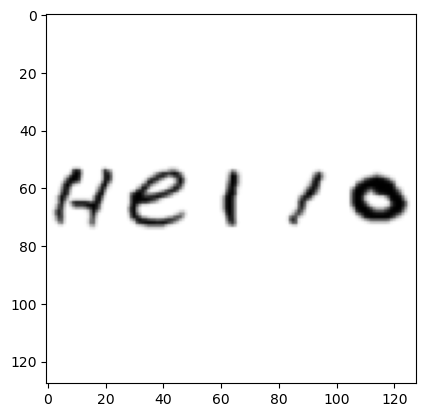

In [6]:
img = get_word_img("Hello", (28*5, 28))
img = resize_word(img)
plt.imshow(img, cmap="gray")